In [1]:
import re
import os
import time
import glob
import joblib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import xrayutilities as xru
from xrayutilities.materials.cif import CIFFile
from xrayutilities.materials.material import Crystal


def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2
    
def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def generate_noisy_xrd(data_y, xrd_x, intensity_variation_range, peak_probability_range):
    
    # Missing peak
    data_y = data_y * np.random.binomial(1, np.random.uniform(*peak_probability_range), data_y.shape[0])

#     # Intensity variation
#     data_y = data_y * np.random.uniform(*intensity_variation_range, data_y.shape[0])
    
#     # Calculate FWHM and Gaussian profiles
#     fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), xrd_x)
#     sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
#     # Create 2D array of Gaussian profiles using broadcasting
#     data_y = gaussian_filter(data_y, sigma=sigma*100)
    
    return data_y

def get_simulated_pattern(index, xrd_dataset):
    return xrd_dataset['xrd_patterns'][index], xrd_dataset['texts'][index], xrd_dataset['labels'][index]

def generate_two_mixed_xrd(idx1,idx2):   ###idx comes from xrd_dataset.xlsx
    new_texts = []
    new_labels = []
    phase1, text1, label1 = get_simulated_pattern(idx1)
    noisy_phase1 = generate_noisy_xrd(phase1, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text1)
    new_labels.append(label1)
    phase2, text2, label2 = get_simulated_pattern(idx2)
    noisy_phase2 = generate_noisy_xrd(phase2, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text2)
    new_labels.append(label2)
    ratio1 = np.random.uniform(0,1)
    ratio2 = 1. - ratio1
    two_mixed_xrd = ratio1 * noisy_phase1 + ratio2 * noisy_phase2
    two_mixed_xrd = two_mixed_xrd / np.max(two_mixed_xrd) * 100.  # Normalize to 100
    return two_mixed_xrd, new_texts, new_labels

F:\Tools\Anaconda\envs\nd2\lib\threading.py:932: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  self.run()
F:\Tools\Anaconda\envs\nd2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# New cif for mix A/B/X perovskite

In [2]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

mix_dic = {}
with open(os.path.join(cif_folder, 'cif_for_mix_ABX.txt')) as file:
    cif_for_mix = [line.rstrip() for line in file]

for data in cif_for_mix:
    cif_name, A, B, X = data.split('\t')
    print(cif_name, A, B, X)
    for x, y in [(A,B),(A,X),(B,X)]:
        mix_element = list(set([A,B,X]) - set([x,y]))[0]
        mix_pos = [A,B,X].index(mix_element)
        try:
            sample_list = mix_dic['{}-{}'.format(x,y)]['sample_list']
            element_list = mix_dic['{}-{}'.format(x,y)]['element_list']
            sample_list.append(cif_name)
            element_list.append(mix_element)
            mix_dic['{}-{}'.format(x,y)]['sample_list'] = sample_list
            mix_dic['{}-{}'.format(x,y)]['element_list'] = element_list
        except:
            mix_dic['{}-{}'.format(x,y)] = {'sample_list':[cif_name], 
                                            'element_list':[mix_element],
                                            'mix_pos':mix_pos}

print(mix_dic)

143881 Cs Sn Br
161481 Cs Pb I
182020 MA Sn I
201251 Cs Pb Cl
231017 Cs Pb Br
235794 MA Pb Br
235795 FA Pb Br
250735 MA Pb I
250736 FA Pb I
262924 Cs Sn I
{'Cs-Sn': {'sample_list': ['143881', '262924'], 'element_list': ['Br', 'I'], 'mix_pos': 2}, 'Cs-Br': {'sample_list': ['143881', '231017'], 'element_list': ['Sn', 'Pb'], 'mix_pos': 1}, 'Sn-Br': {'sample_list': ['143881'], 'element_list': ['Cs'], 'mix_pos': 0}, 'Cs-Pb': {'sample_list': ['161481', '201251', '231017'], 'element_list': ['I', 'Cl', 'Br'], 'mix_pos': 2}, 'Cs-I': {'sample_list': ['161481', '262924'], 'element_list': ['Pb', 'Sn'], 'mix_pos': 1}, 'Pb-I': {'sample_list': ['161481', '250735', '250736'], 'element_list': ['Cs', 'MA', 'FA'], 'mix_pos': 0}, 'MA-Sn': {'sample_list': ['182020'], 'element_list': ['I'], 'mix_pos': 2}, 'MA-I': {'sample_list': ['182020', '250735'], 'element_list': ['Sn', 'Pb'], 'mix_pos': 1}, 'Sn-I': {'sample_list': ['182020', '262924'], 'element_list': ['MA', 'Cs'], 'mix_pos': 0}, 'Cs-Cl': {'sample_list'

In [3]:
for shared_element, data in mix_dic.items():
    sample_list = data['sample_list']
    element_list = data['element_list']
    mix_pos = data['mix_pos']
    shared_element_list = shared_element.split('-')
    
    if len(sample_list) > 1:
        sample_pair_list = [(sample1, sample2) for i, sample1 in enumerate(sample_list) for sample2 in sample_list[i + 1:]]
        
        for (sample1, sample2) in sample_pair_list:
            structure1 = Structure.from_file(os.path.join(cif_folder, sample1+'.cif'))
            abc1 = np.array(structure1.lattice.abc)
            structure2 = Structure.from_file(os.path.join(cif_folder, sample2+'.cif'))
            abc2 = np.array(structure2.lattice.abc)
            strain3D_list = np.linspace([0,0,0],abc2/abc1-1,11)[1:-1]
            
            for i, strain in enumerate(strain3D_list):
                formula = shared_element_list.copy()
                formula.insert(mix_pos, element_list[sample_list.index(sample2)]+'0.{}'.format(i+1))
                formula.insert(mix_pos, element_list[sample_list.index(sample1)]+'0.{}'.format(9-i))
                formula = ''.join(formula)
                print(formula)
                structure1.apply_strain(strain)
                structure1.to(os.path.join(cif_folder, 'mix', '{}.cif'.format(formula)))
                structure1.apply_strain(1/(1+strain)-1)

CsSnBr0.9I0.1
CsSnBr0.8I0.2
CsSnBr0.7I0.3
CsSnBr0.6I0.4
CsSnBr0.5I0.5
CsSnBr0.4I0.6
CsSnBr0.3I0.7
CsSnBr0.2I0.8
CsSnBr0.1I0.9
CsSn0.9Pb0.1Br
CsSn0.8Pb0.2Br
CsSn0.7Pb0.3Br
CsSn0.6Pb0.4Br
CsSn0.5Pb0.5Br
CsSn0.4Pb0.6Br
CsSn0.3Pb0.7Br
CsSn0.2Pb0.8Br
CsSn0.1Pb0.9Br
CsPbI0.9Cl0.1
CsPbI0.8Cl0.2
CsPbI0.7Cl0.3
CsPbI0.6Cl0.4
CsPbI0.5Cl0.5
CsPbI0.4Cl0.6
CsPbI0.3Cl0.7
CsPbI0.2Cl0.8
CsPbI0.1Cl0.9
CsPbI0.9Br0.1
CsPbI0.8Br0.2
CsPbI0.7Br0.3
CsPbI0.6Br0.4
CsPbI0.5Br0.5
CsPbI0.4Br0.6
CsPbI0.3Br0.7
CsPbI0.2Br0.8
CsPbI0.1Br0.9
CsPbCl0.9Br0.1
CsPbCl0.8Br0.2
CsPbCl0.7Br0.3
CsPbCl0.6Br0.4
CsPbCl0.5Br0.5
CsPbCl0.4Br0.6
CsPbCl0.3Br0.7
CsPbCl0.2Br0.8
CsPbCl0.1Br0.9
CsPb0.9Sn0.1I
CsPb0.8Sn0.2I
CsPb0.7Sn0.3I
CsPb0.6Sn0.4I
CsPb0.5Sn0.5I
CsPb0.4Sn0.6I
CsPb0.3Sn0.7I
CsPb0.2Sn0.8I
CsPb0.1Sn0.9I
Cs0.9MA0.1PbI
Cs0.8MA0.2PbI
Cs0.7MA0.3PbI
Cs0.6MA0.4PbI
Cs0.5MA0.5PbI
Cs0.4MA0.6PbI
Cs0.3MA0.7PbI
Cs0.2MA0.8PbI
Cs0.1MA0.9PbI
Cs0.9FA0.1PbI
Cs0.8FA0.2PbI
Cs0.7FA0.3PbI
Cs0.6FA0.4PbI
Cs0.5FA0.5PbI
Cs0.4FA0.6PbI
Cs0.3FA0.7PbI
Cs

F:\Tools\Anaconda\envs\nd2\lib\site-packages\pymatgen\io\cif.py:1168: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


MA0.9FA0.1PbI
MA0.8FA0.2PbI
MA0.7FA0.3PbI
MA0.6FA0.4PbI
MA0.5FA0.5PbI
MA0.4FA0.6PbI
MA0.3FA0.7PbI
MA0.2FA0.8PbI
MA0.1FA0.9PbI
MASn0.9Pb0.1I
MASn0.8Pb0.2I
MASn0.7Pb0.3I
MASn0.6Pb0.4I
MASn0.5Pb0.5I
MASn0.4Pb0.6I
MASn0.3Pb0.7I
MASn0.2Pb0.8I
MASn0.1Pb0.9I
MA0.9Cs0.1SnI
MA0.8Cs0.2SnI
MA0.7Cs0.3SnI
MA0.6Cs0.4SnI
MA0.5Cs0.5SnI
MA0.4Cs0.6SnI
MA0.3Cs0.7SnI
MA0.2Cs0.8SnI
MA0.1Cs0.9SnI
Cs0.9MA0.1PbBr
Cs0.8MA0.2PbBr
Cs0.7MA0.3PbBr
Cs0.6MA0.4PbBr
Cs0.5MA0.5PbBr
Cs0.4MA0.6PbBr
Cs0.3MA0.7PbBr
Cs0.2MA0.8PbBr
Cs0.1MA0.9PbBr
Cs0.9FA0.1PbBr
Cs0.8FA0.2PbBr
Cs0.7FA0.3PbBr
Cs0.6FA0.4PbBr
Cs0.5FA0.5PbBr
Cs0.4FA0.6PbBr
Cs0.3FA0.7PbBr
Cs0.2FA0.8PbBr
Cs0.1FA0.9PbBr
MA0.9FA0.1PbBr
MA0.8FA0.2PbBr
MA0.7FA0.3PbBr
MA0.6FA0.4PbBr
MA0.5FA0.5PbBr
MA0.4FA0.6PbBr
MA0.3FA0.7PbBr
MA0.2FA0.8PbBr
MA0.1FA0.9PbBr
MAPbBr0.9I0.1
MAPbBr0.8I0.2
MAPbBr0.7I0.3
MAPbBr0.6I0.4
MAPbBr0.5I0.5
MAPbBr0.4I0.6
MAPbBr0.3I0.7
MAPbBr0.2I0.8
MAPbBr0.1I0.9
FAPbBr0.9I0.1
FAPbBr0.8I0.2
FAPbBr0.7I0.3
FAPbBr0.6I0.4
FAPbBr0.5I0.5
FAPbBr0.4I0.6
FAPbBr0

# Preprocess

In [4]:
# folder = r'/Users/shengfang/Dropbox (MIT)/XRD phase identification/'
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

xrd_calculator = XRDCalculator(wavelength="CuKa1")
# xrd_x = np.arange(5.00, 60.01, 0.01)
strain1D_list = list(np.linspace(-0.01,0.01,3))
strain3D_list = np.array(np.meshgrid(strain1D_list,strain1D_list,strain1D_list)).T.reshape(-1,3)
possible_element = ['Cs','FA','MA','Pb','Sn','I','Br','Cl']

dataset = {}

# Load mix cif
for cif_file in os.listdir(os.path.join(cif_folder, 'mix')):
    if cif_file.endswith('.cif'):
        structure = Structure.from_file(os.path.join(cif_folder, 'mix', cif_file))
        space_group = SpacegroupAnalyzer(structure).get_crystal_system()
        formula = cif_file[:-4]
        element_list = []
        halide_list = []
        for element in possible_element:
            if element in formula:
                element_list.append(element)
                if element in ['I','Br','Cl']:
                    halide_list.append(element)
        if len(halide_list) > 1:
            first_halide_index = min(formula.index(halide_list[0]),formula.index(halide_list[-1]))
            formula = formula[:first_halide_index] + '(' + formula[first_halide_index:] + ')3'
        else:
            formula = formula + '3'
            
        print('Processing {}'.format(formula))
        xrd_list = []
        time_start = time.time()
        for strain in strain3D_list:
            structure.apply_strain(strain)
            xrd_pattern = xrd_calculator.get_pattern(structure)
            mask = (xrd_pattern.x >= 5) & (xrd_pattern.x <= 60)
            xrd_list.append((xrd_pattern.x[mask], xrd_pattern.y[mask]))
            structure.apply_strain(1/(1+strain)-1)
        print('Finished in {} s.'.format(time.time() - time_start))
        
        dataset[cif_file[:-4]] = {'formula':formula, 'element_list':element_list, 'space_group':space_group, 'xrd_list':xrd_list}
        print(formula,space_group,element_list)

Processing Cs0.1FA0.9PbBr3
Finished in 2.1047451496124268 s.
Cs0.1FA0.9PbBr3 cubic ['Cs', 'FA', 'Pb', 'Br']
Processing Cs0.1FA0.9PbI3
Finished in 7.113139629364014 s.
Cs0.1FA0.9PbI3 tetragonal ['Cs', 'FA', 'Pb', 'I']
Processing Cs0.1MA0.9PbBr3
Finished in 1.7800366878509521 s.
Cs0.1MA0.9PbBr3 cubic ['Cs', 'MA', 'Pb', 'Br']
Processing Cs0.1MA0.9PbI3
Finished in 2.024167776107788 s.
Cs0.1MA0.9PbI3 cubic ['Cs', 'MA', 'Pb', 'I']
Processing Cs0.2FA0.8PbBr3
Finished in 1.8090214729309082 s.
Cs0.2FA0.8PbBr3 cubic ['Cs', 'FA', 'Pb', 'Br']
Processing Cs0.2FA0.8PbI3
Finished in 6.291528224945068 s.
Cs0.2FA0.8PbI3 tetragonal ['Cs', 'FA', 'Pb', 'I']
Processing Cs0.2MA0.8PbBr3
Finished in 1.7478840351104736 s.
Cs0.2MA0.8PbBr3 cubic ['Cs', 'MA', 'Pb', 'Br']
Processing Cs0.2MA0.8PbI3
Finished in 2.0964016914367676 s.
Cs0.2MA0.8PbI3 cubic ['Cs', 'MA', 'Pb', 'I']
Processing Cs0.3FA0.7PbBr3
Finished in 1.8654811382293701 s.
Cs0.3FA0.7PbBr3 cubic ['Cs', 'FA', 'Pb', 'Br']
Processing Cs0.3FA0.7PbI3
Finishe

Finished in 1.5830395221710205 s.
CsSn0.5Pb0.5Br3 cubic ['Cs', 'Pb', 'Sn', 'Br']
Processing CsSn0.6Pb0.4Br3
Finished in 1.6213386058807373 s.
CsSn0.6Pb0.4Br3 cubic ['Cs', 'Pb', 'Sn', 'Br']
Processing CsSn0.7Pb0.3Br3
Finished in 1.6296794414520264 s.
CsSn0.7Pb0.3Br3 cubic ['Cs', 'Pb', 'Sn', 'Br']
Processing CsSn0.8Pb0.2Br3
Finished in 1.5936791896820068 s.
CsSn0.8Pb0.2Br3 cubic ['Cs', 'Pb', 'Sn', 'Br']
Processing CsSn0.9Pb0.1Br3
Finished in 1.601733922958374 s.
CsSn0.9Pb0.1Br3 cubic ['Cs', 'Pb', 'Sn', 'Br']
Processing CsSn(Br0.1I0.9)3
Finished in 1.9143447875976562 s.
CsSn(Br0.1I0.9)3 cubic ['Cs', 'Sn', 'I', 'Br']
Processing CsSn(Br0.2I0.8)3
Finished in 1.8934133052825928 s.
CsSn(Br0.2I0.8)3 cubic ['Cs', 'Sn', 'I', 'Br']
Processing CsSn(Br0.3I0.7)3
Finished in 1.9162845611572266 s.
CsSn(Br0.3I0.7)3 cubic ['Cs', 'Sn', 'I', 'Br']
Processing CsSn(Br0.4I0.6)3
Finished in 1.9032094478607178 s.
CsSn(Br0.4I0.6)3 cubic ['Cs', 'Sn', 'I', 'Br']
Processing CsSn(Br0.5I0.5)3
Finished in 1.8528516292

In [5]:
ICSD_label_list = []
with open(os.path.join(cif_folder, 'label.txt')) as file:
    for line in file:
        ICSD_label_list.append(line.rstrip().split('\t'))
ICSD_label_list = np.array(ICSD_label_list)
print(ICSD_label_list)

[['21955' 'CsPbI3' 'gamma-CsPbI3']
 ['32306' 'CsPbI3' 'delta-CsPbI3']
 ['42013' 'PbI2' 'PbI2']
 ['44540' 'Cs4PbBr6' 'Cs4PbBr6']
 ['48997' 'CsPb2Br5' 'CsPb2Br5']
 ['56522' 'CsI' 'CsI']
 ['84525' 'CsPbBr3' 'orthorhombic-CsPbBr3']
 ['161481' 'CsPbI3' 'alpha-CsPbI3']
 ['230491' 'FAPbI3' 'delta-FAPbI3']
 ['230492' 'FAPbI3' 'beta-FAPbI3']
 ['235794' 'MAPbBr3' 'cubic-MAPbBr3']
 ['235795' 'FAPbBr3' 'cubic-FAPbBr3']
 ['236387' 'CsBr' 'CsBr']
 ['238610' 'MAPbI3' 'tetragonal-MAPbI3']
 ['239760' 'PbBr2' 'PbBr2']
 ['250736' 'FAPbI3' 'alpha-FAPbI3']
 ['250741' 'FAPbI3' 'delta-FAPbI3']
 ['434338' 'CsPbI3' 'gamma-CsPbI3']
 ['33037' 'MAPbBr3' 'tetragonal-MAPbBr3']
 ['231017' 'CsPbBr3' 'cubic-CsPbBr3']
 ['250735' 'MAPbI3' 'alpha-MAPbI3']
 ['143881' 'CsSnBr3' 'CsSnBr3']
 ['182020' 'MASnI3' 'MASnI3']
 ['262924' 'CsSnI3' 'CsSnI3']
 ['760468' 'Cs2SnBr6' 'Cs2SnBr6']
 ['201251' 'CsPbCl3' 'cubic-CsPbCl3']
 ['230496' 'CsPbCl3' 'Pbnm-CsPbCl3']
 ['241415' 'MAPbCl3' 'Pnma-MAPbCl3']
 ['243734' 'CsPbCl3' 'Pnma-CsPbC

In [6]:
# Load ICSD cif
for i, cif_file in enumerate(ICSD_label_list[:,0]):
    
    structure = Structure.from_file(os.path.join(cif_folder, cif_file+'.cif'))
    space_group = SpacegroupAnalyzer(structure).get_crystal_system()
    element_list = []
    for element in possible_element:
        if element in ICSD_label_list[i,1]:
            element_list.append(element)
    formula = ICSD_label_list[i,2]
    print(cif_file, element_list, formula)

    print('Processing {}'.format(formula))
    xrd_list = []
    time_start = time.time()
    for strain in strain3D_list:
        structure.apply_strain(strain)
        xrd_pattern = xrd_calculator.get_pattern(structure)
        mask = (xrd_pattern.x >= 5) & (xrd_pattern.x <= 60)
        xrd_list.append((xrd_pattern.x[mask], xrd_pattern.y[mask]))
        structure.apply_strain(1/(1+strain)-1)
    print('Finished in {} s.'.format(time.time() - time_start))

#         data_y = np.zeros_like(xrd_x)
#         indices = np.searchsorted(xrd_x, xrd_pattern.x[mask])
#         data_y[indices] = xrd_pattern.y[mask]

    dataset[cif_file] = {'formula':formula, 'element_list':element_list, 'space_group':space_group, 'xrd_list':xrd_list}
        
with open(os.path.join(cif_folder, 'dataset.npy'), 'wb') as handle:
    joblib.dump(dataset, handle)

21955 ['Cs', 'Pb', 'I'] gamma-CsPbI3
Processing gamma-CsPbI3
Finished in 8.978762149810791 s.
32306 ['Cs', 'Pb', 'I'] delta-CsPbI3
Processing delta-CsPbI3
Finished in 8.769649028778076 s.
42013 ['Pb', 'I'] PbI2
Processing PbI2
Finished in 1.048734188079834 s.
44540 ['Cs', 'Pb', 'Br'] Cs4PbBr6
Processing Cs4PbBr6
Finished in 35.7341468334198 s.
48997 ['Cs', 'Pb', 'Br'] CsPb2Br5
Processing CsPb2Br5
Finished in 10.451256036758423 s.
56522 ['Cs', 'I'] CsI
Processing CsI
Finished in 0.7744598388671875 s.
84525 ['Cs', 'Pb', 'Br'] orthorhombic-CsPbBr3
Processing orthorhombic-CsPbBr3
Finished in 7.398212194442749 s.
161481 ['Cs', 'Pb', 'I'] alpha-CsPbI3
Processing alpha-CsPbI3
Finished in 2.085387706756592 s.
230491 ['FA', 'Pb', 'I'] delta-FAPbI3
Processing delta-FAPbI3
Finished in 6.000474452972412 s.
230492 ['FA', 'Pb', 'I'] beta-FAPbI3
Processing beta-FAPbI3
Finished in 4.186540126800537 s.
235794 ['MA', 'Pb', 'Br'] cubic-MAPbBr3
Processing cubic-MAPbBr3
Finished in 1.8762154579162598 s.
23

In [7]:
dataset['FAPbBr0.9I0.1']

{'formula': 'FAPb(Br0.9I0.1)3',
 'element_list': ['FA', 'Pb', 'I', 'Br'],
 'space_group': 'tetragonal',
 'xrd_list': [(array([13.76380949, 14.2089472 , 19.83194083, 20.14666194, 24.48098912,
          27.73136634, 28.64244402, 31.29037968, 31.90637566, 32.10935381,
          34.51750721, 35.08303766, 40.29124588, 40.95223456, 42.13528811,
          42.93102626, 43.4028073 , 43.55915592, 44.68612257, 45.89718832,
          46.04682056, 47.12690143, 48.290429  , 50.17870004, 51.74292522,
          52.4247907 , 52.9658155 , 53.94242284, 54.60504963, 55.0000192 ,
          57.27849911, 59.30202675, 59.3386281 ]),
   array([5.35397902e+01, 1.00000000e+02, 3.63005083e+01, 1.74984010e+01,
          2.87615821e+00, 3.62770927e+01, 6.67425283e+01, 3.75221987e+01,
          3.57036508e+01, 3.51293202e+01, 1.04042983e+01, 1.99346886e+01,
          4.54310422e+01, 2.16883932e+01, 3.25582186e+00, 3.35416277e+01,
          1.62646572e+01, 5.93481919e+00, 3.32676807e+00, 3.08859173e+00,
          3.0

In [8]:
dataset['161481']

{'formula': 'alpha-CsPbI3',
 'element_list': ['Cs', 'Pb', 'I'],
 'space_group': 'cubic',
 'xrd_list': [(array([14.21251242, 20.15174356, 24.74560745, 28.64974671, 32.11758581,
          35.27888058, 40.96291616, 43.57058553, 46.05897677, 48.44724906,
          50.75031509, 52.98006725, 55.14618485, 59.31831106]),
   array([ 39.803887  ,  39.47865459,  35.84975981, 100.        ,
           23.52751584,  20.06418738,  76.00404676,  13.03231801,
            9.64135303,  16.03237345,  27.15075675,   5.92341872,
           11.47702135,  12.75425188])),
  (array([14.06966509, 14.21251242, 20.05019694, 20.15174356, 24.66210245,
          28.35722167, 28.64974671, 31.85405169, 32.05188386, 32.11758581,
          35.03645337, 35.21841007, 40.74951913, 40.96291616, 43.11295716,
          43.36767301, 43.51992838, 43.57058553, 45.62115478, 46.01048969,
          46.05897677, 48.02615864, 48.40059721, 50.5698177 , 52.58565168,
          52.80502591, 52.98006725, 54.7625347 , 54.97589602, 55.103645

# ----- Playground (not in use) ----- 

In [9]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

with open(os.path.join(cif_folder, 'dataset.npy'), 'rb') as handle:
    dataset = joblib.load(handle)

time_start = time.time()

# Parameters for error generation
twotheta = np.arange(5.00, 60.01, 0.01)
crystal_size_range = (5, 20)

intensity_variation_range = (0.2, 1)  # percentage
peak_probability_range = (0.2, 1)  # probability of peak
num_patterns = 1000  # number of noisy patterns to generate per CIF file

# Iterate through simulated XRD patterns
xrd_patterns_list = []
texts_list = []
labels_list = []

for i in range(0, len(xrd_dataset['xrd_patterns'])):
    data_y, texts, labels = get_simulated_pattern(i, xrd_dataset)
    for j in range(0, num_patterns):
        data_ys = generate_noisy_xrd(data_y, xrd_x, intensity_variation_range, peak_probability_range)
        xrd_patterns_list.append(data_ys/np.max(data_ys))
        texts_list.append(texts)
        labels_list.append(labels)

noisy_xrd_dataset = {
    "xrd_patterns": xrd_patterns_list,
    "texts": texts_list,
    "labels": labels_list
}

with open(noisy_xrd_dataset_path, 'wb') as handle:
    joblib.dump(noisy_xrd_dataset, handle)

print('Finished in {} s.'.format(time.time() - time_start))

Finished in 6.196119070053101 s.


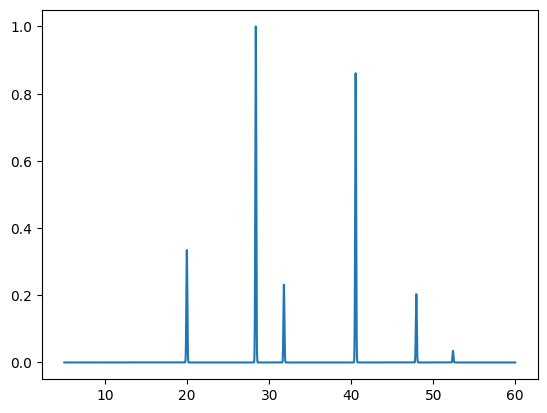

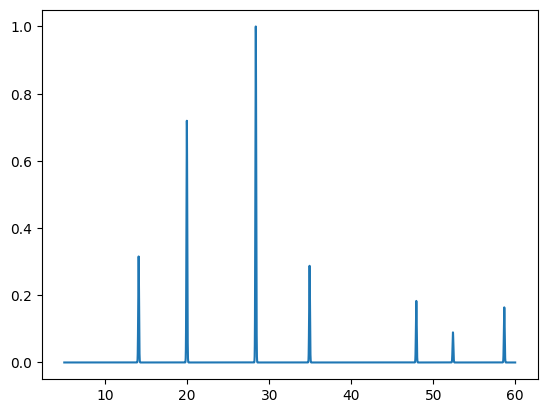

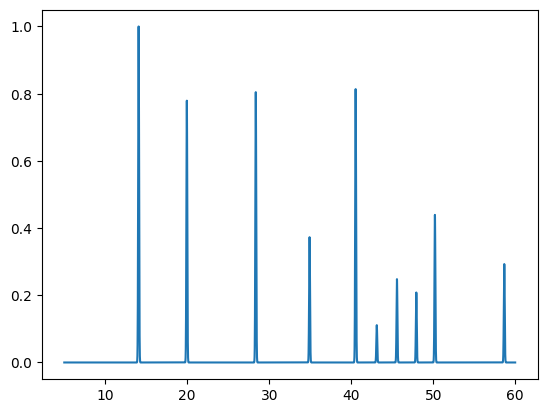

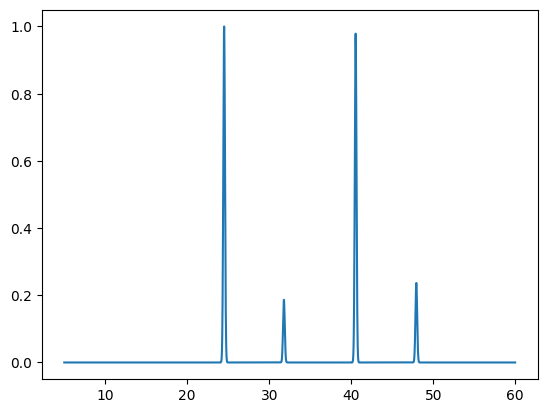

In [32]:
plt.figure(0)
plt.plot(xrd_x, xrd_patterns_list[0])
plt.figure(1)
plt.plot(xrd_x, xrd_patterns_list[1])
plt.figure(2)
plt.plot(xrd_x, xrd_patterns_list[2])
plt.figure(3)
plt.plot(xrd_x, xrd_patterns_list[3])

(5501,)


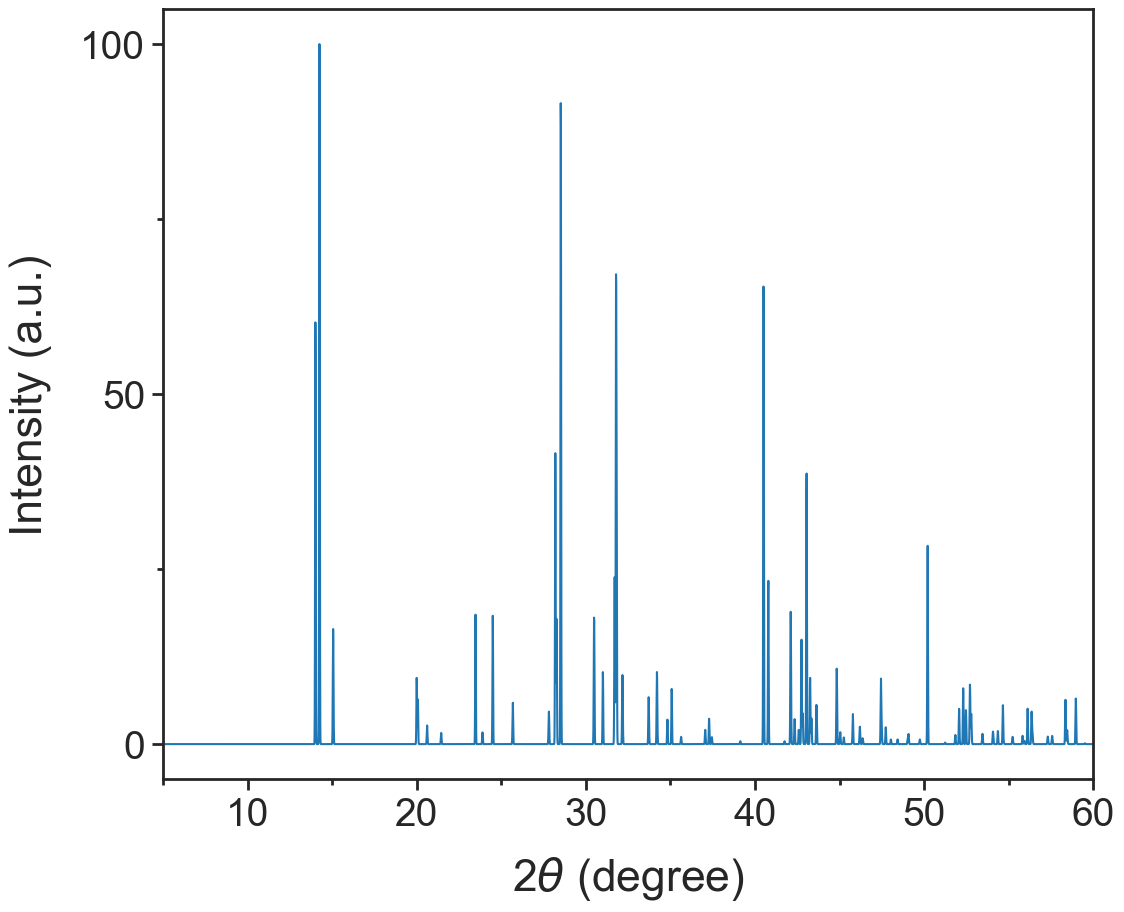

(5501,)


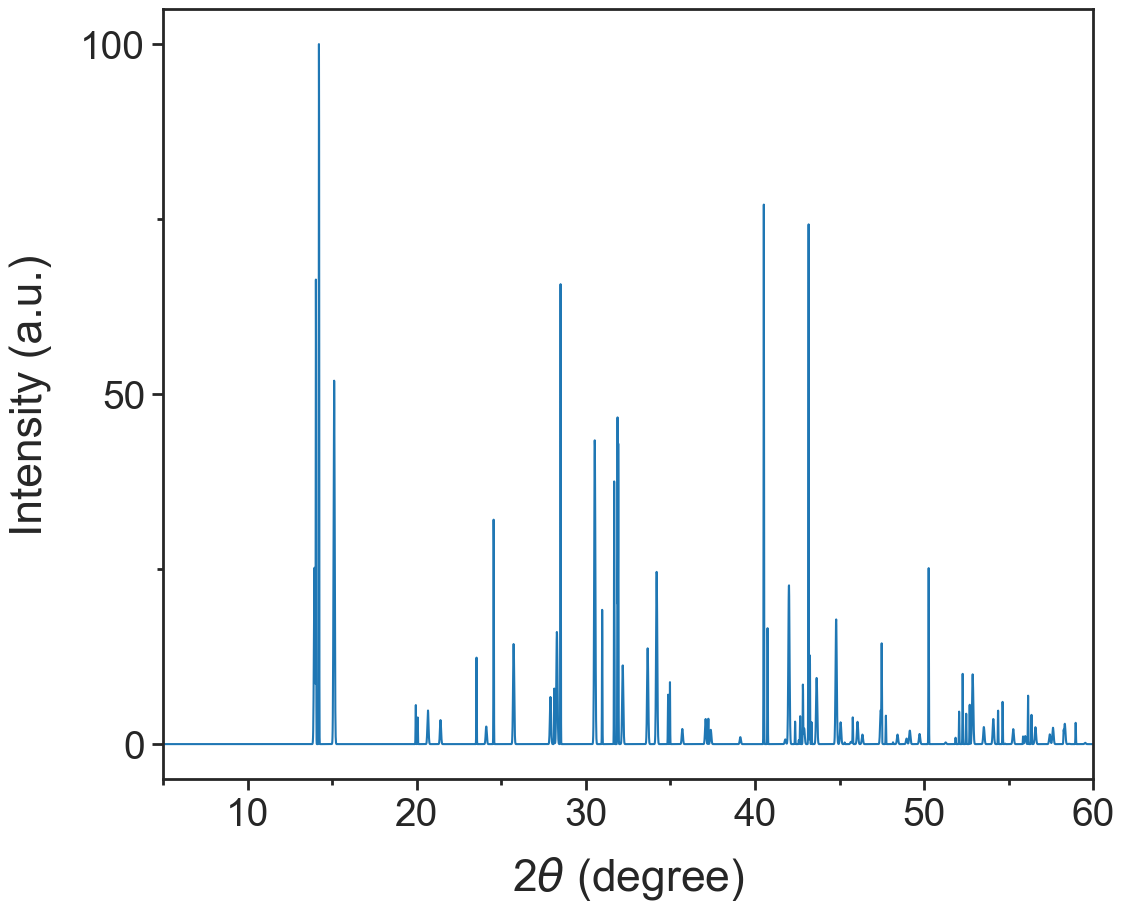

(5501,)


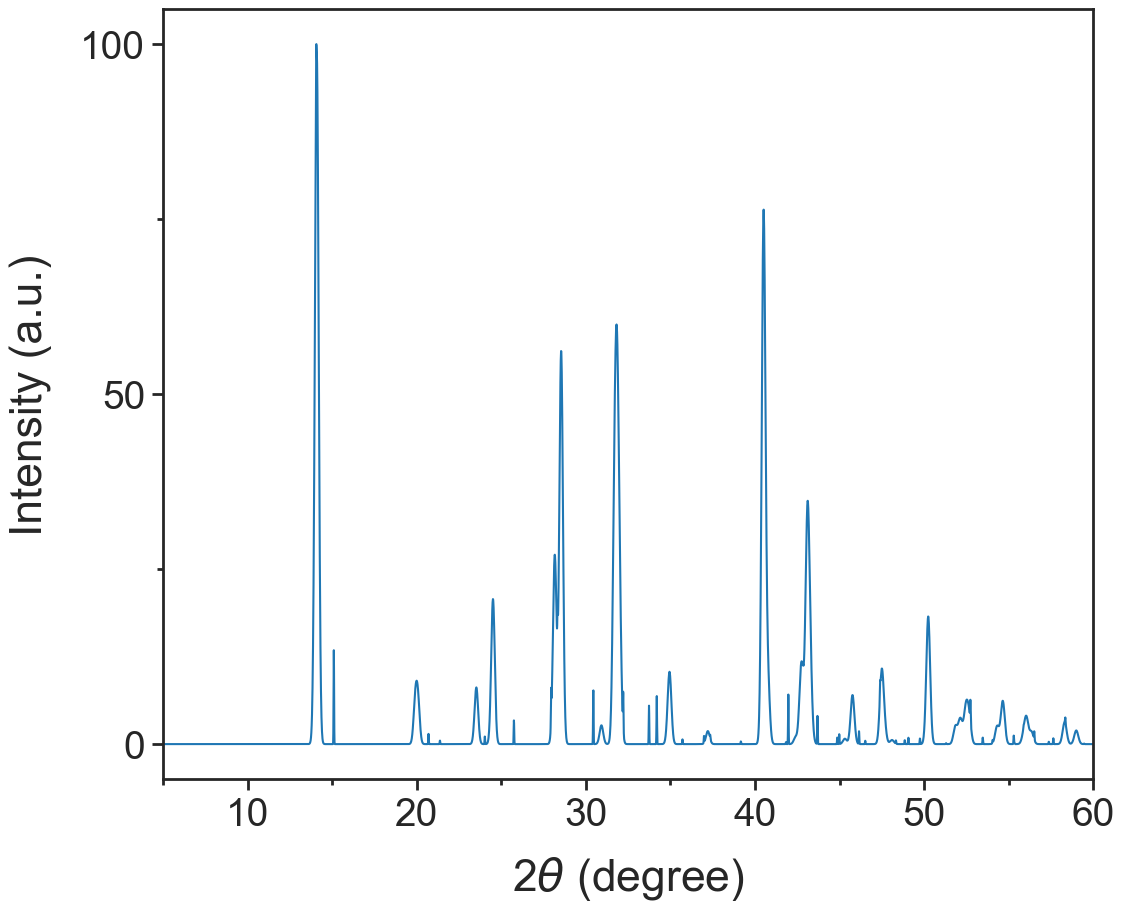

(5501,)


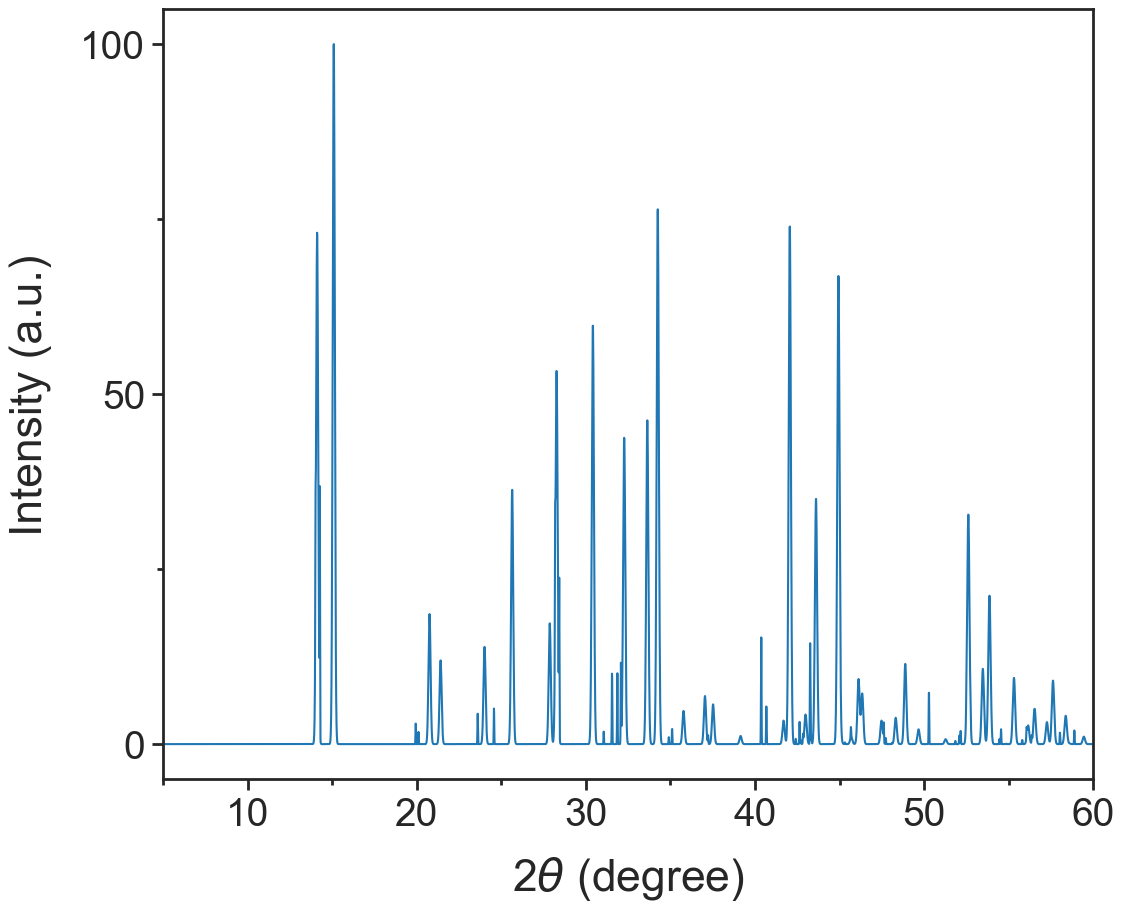

(5501,)


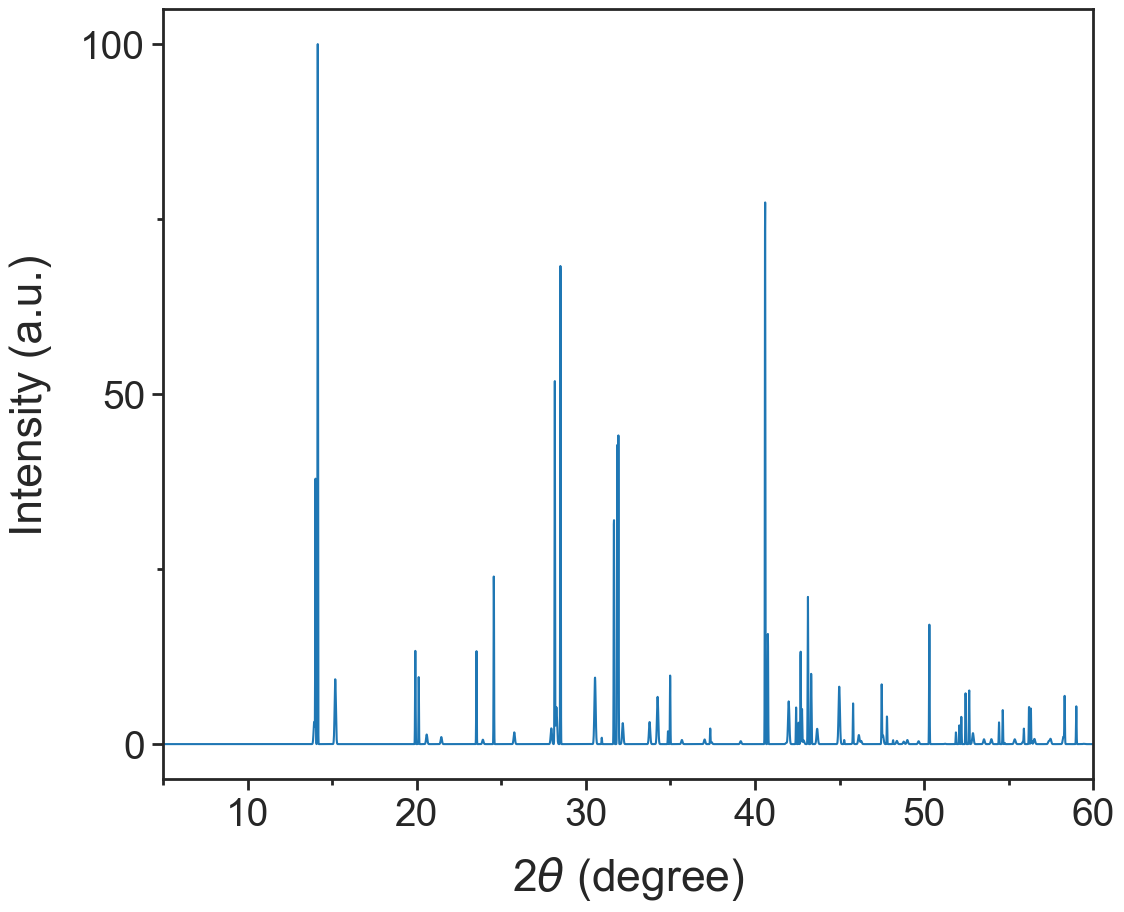

(5501,)


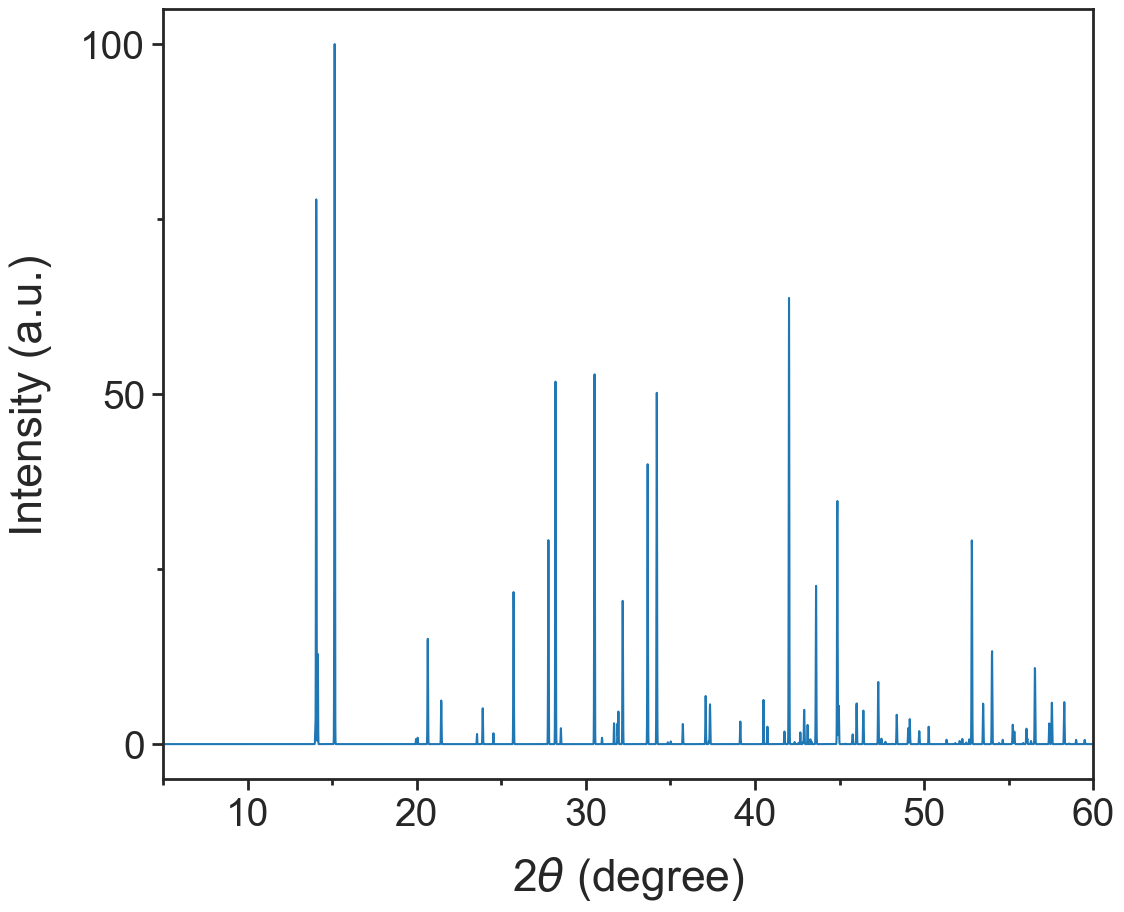

(5501,)


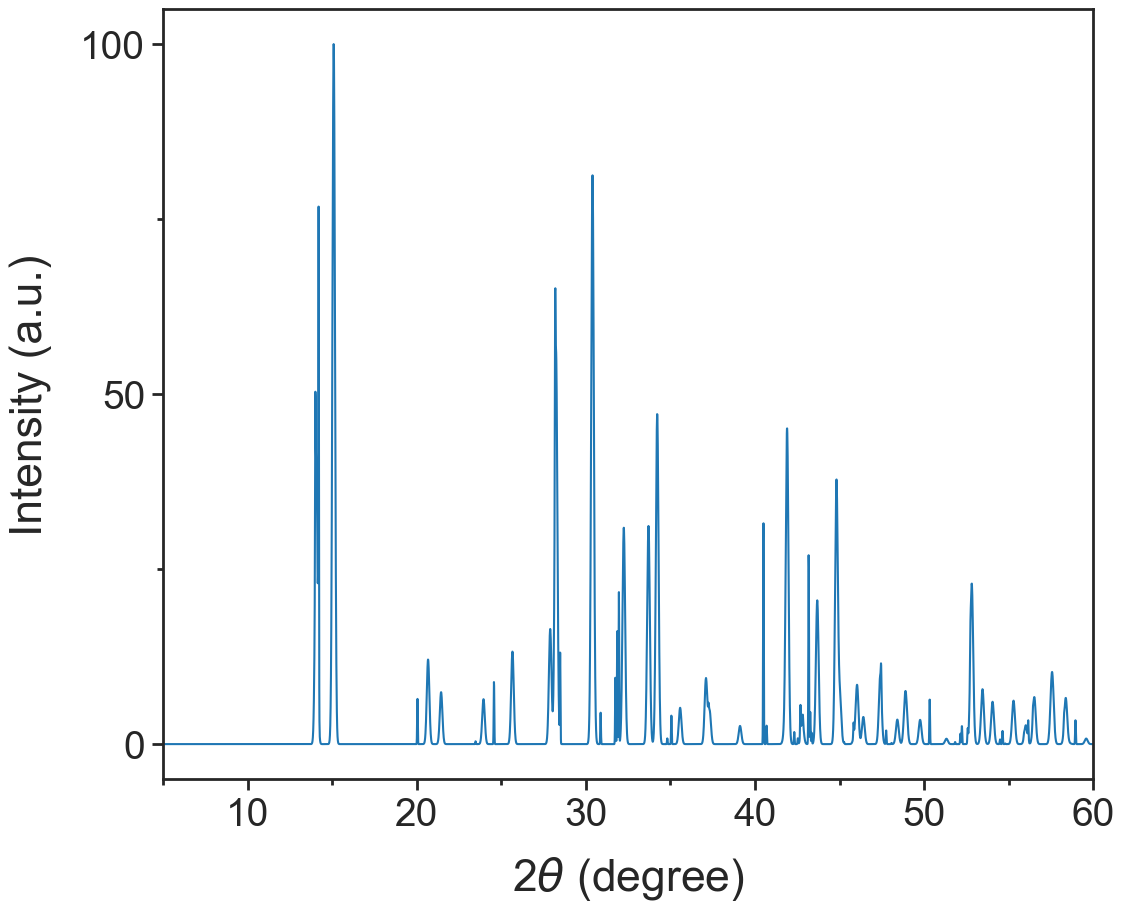

(5501,)


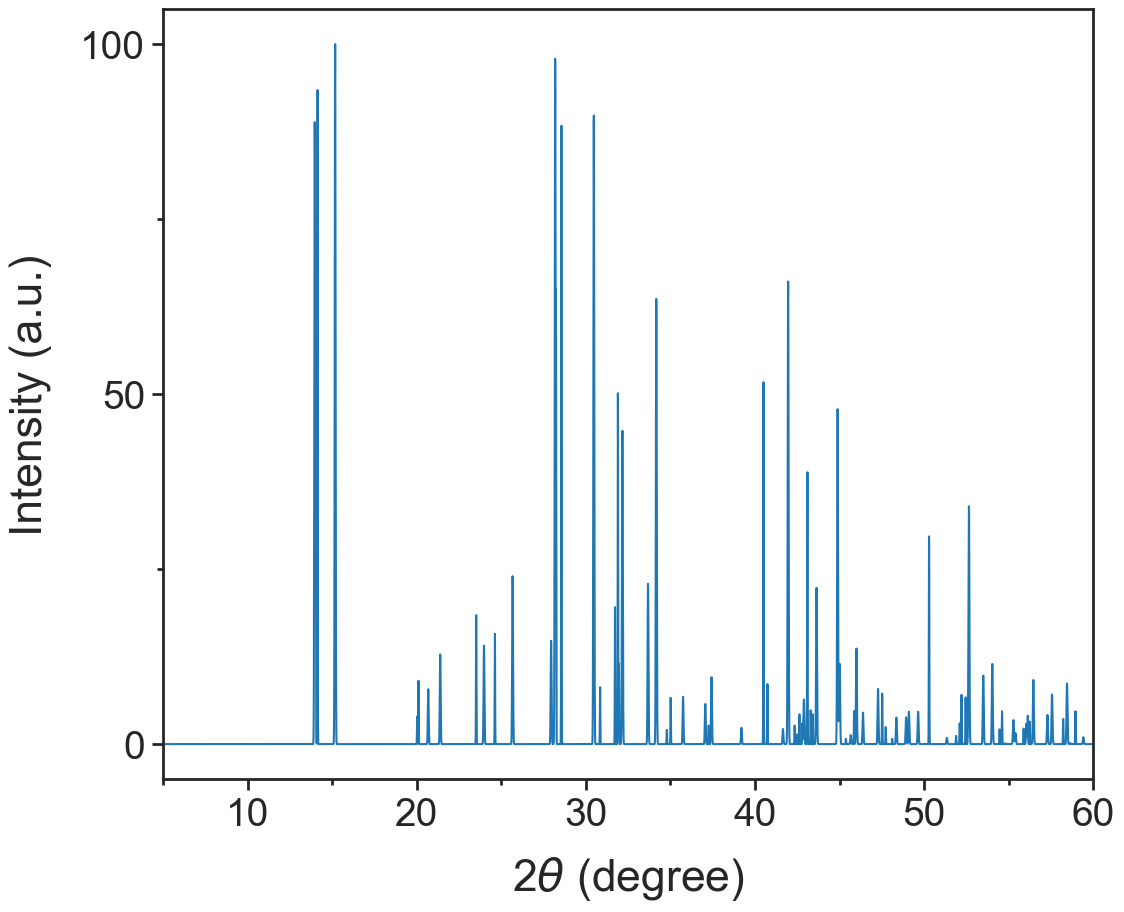

(5501,)


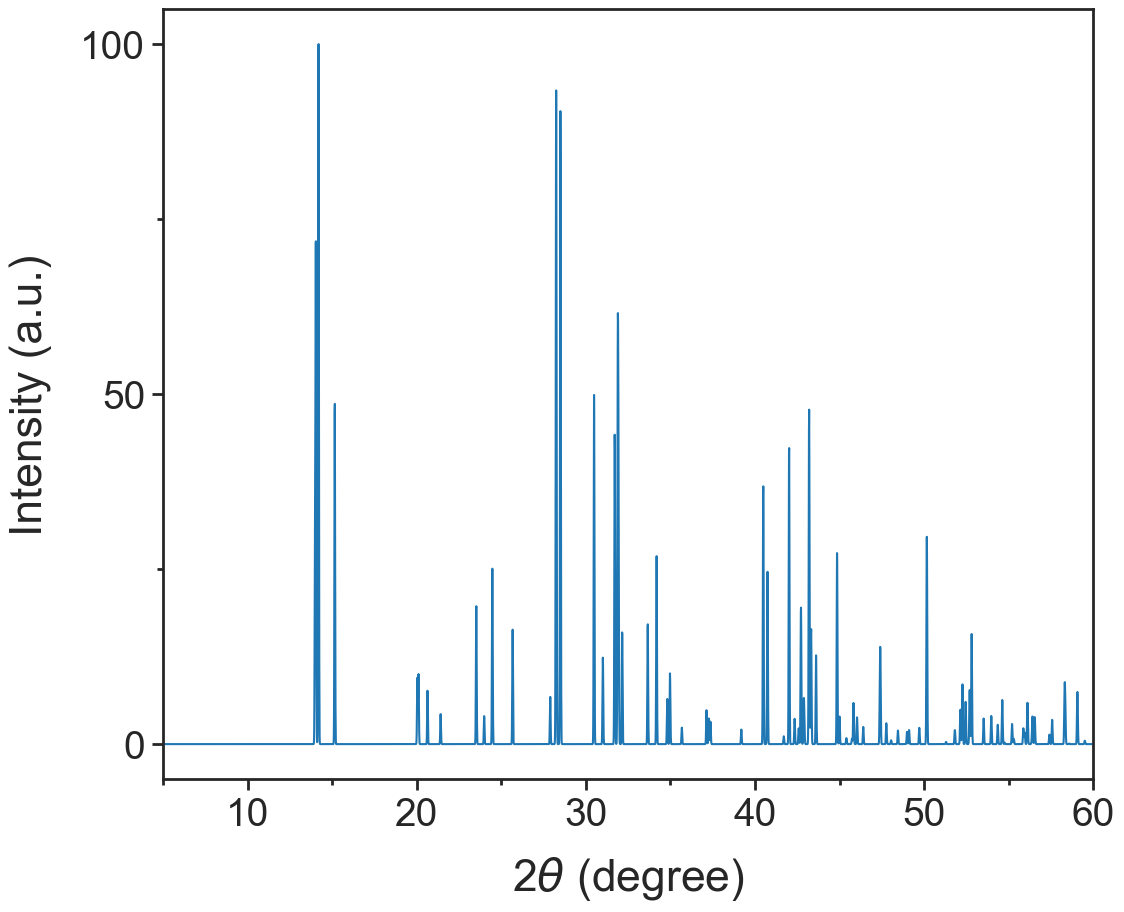

(5501,)


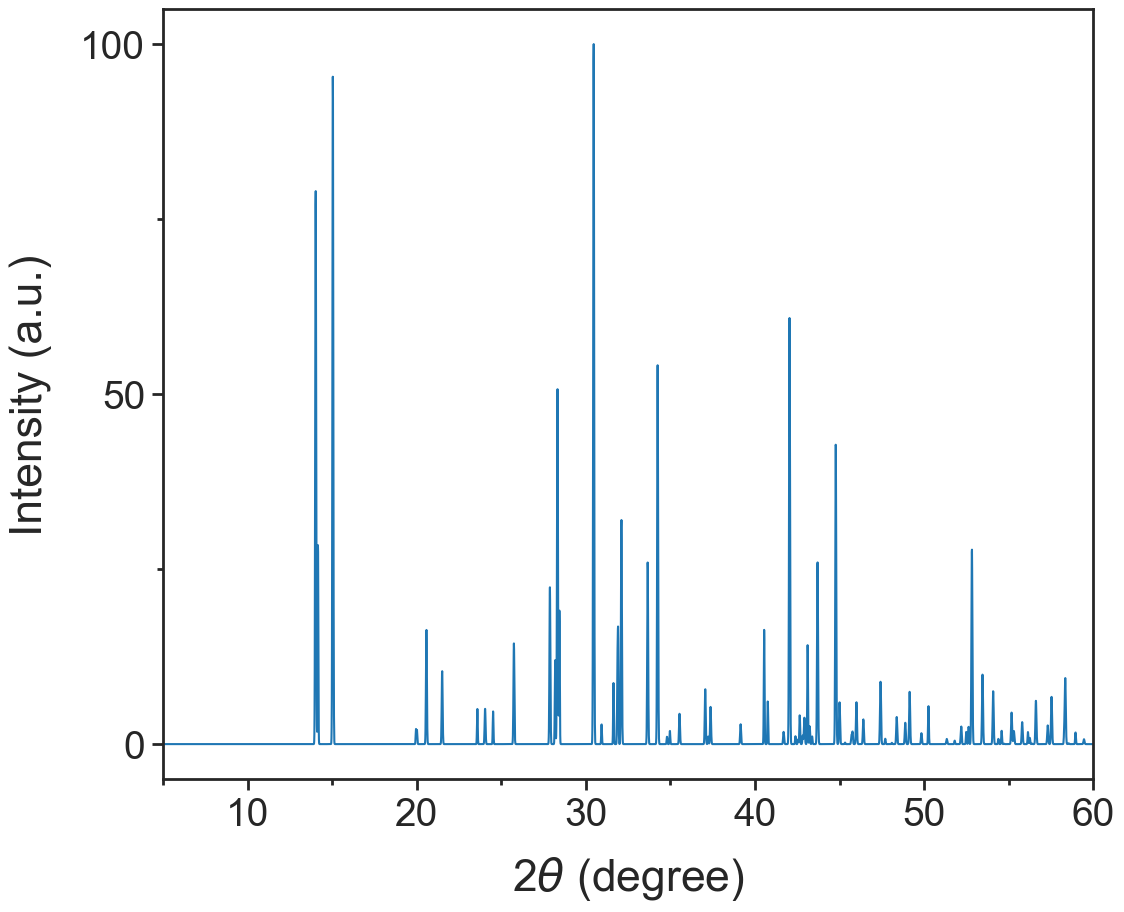

In [345]:
# Parameters for generation
crystal_size_range = (5, 50)  # A
position_shift_std_range = (0.01, 0.1)  # degrees 2θ
intensity_variation_std_range = (0.1, 0.5)  # percentage
peak_loss_probability_range = (0.2, 0.5)  # probability of peak loss
num_two_mixed_patterns = 10  # number of noisy patterns to generate per CIF file

# two phases mixed XRD pattern generation
xrd_patterns_list = []
texts_list = []
labels_list = []
idx1 = 0
idx2 = 1

two_mixed_dataset_path = os.path.join(folder, 'two_mixed_dataset_{}_{}.npy'.format(idx1,idx2))

for j in range(0,num_two_mixed_patterns):
    two_mixed_xrd, texts, labels = generate_two_mixed_xrd(idx1,idx2)
    print(two_mixed_xrd.shape)
    # Plot the XRD pattern
    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.plot(two_theta_range, two_mixed_xrd)
    ax.set_xlabel(r'2$\theta$ (degree)',labelpad=15,size=32)
    ax.set_ylabel('Intensity (a.u.)',labelpad=20,size=32)
    # ax.set_title('CsBiI-CsBiBr')
    # ax.set_ylim(-5,105)
    ax.set_xlim(5, 60)
    ax.tick_params(axis='both', direction='out', length=8, width=2, pad=5, labelsize=28)
    ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=5)
    ax.minorticks_on()
    ax.yaxis.set_ticks([])
    # plt.legend(fontsize=16)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=False, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    # plt.savefig(f'/Users/shengfang/Dropbox (MIT)/high entropy/XRD/20240821/figure.svg', bbox_inches='tight',format='svg', dpi=300)
    # plt.savefig(f'/Users/shengfang/Dropbox (MIT)/high entropy/XRD/20240821/figure.png', bbox_inches='tight',format='png', dpi=300)
    plt.show()
    two_mixed_xrd_str = ";".join(map(str, two_mixed_xrd))
    xrd_patterns_list.append(two_mixed_xrd_str)
    texts_list.append(texts)
    labels_list.append(labels)

df = pd.DataFrame({
    "xrd_patterns": xrd_patterns_list,
    "texts": texts_list,
    "labels": labels_list
})

df.to_excel(output_excel_path, index=False)

(5501,)


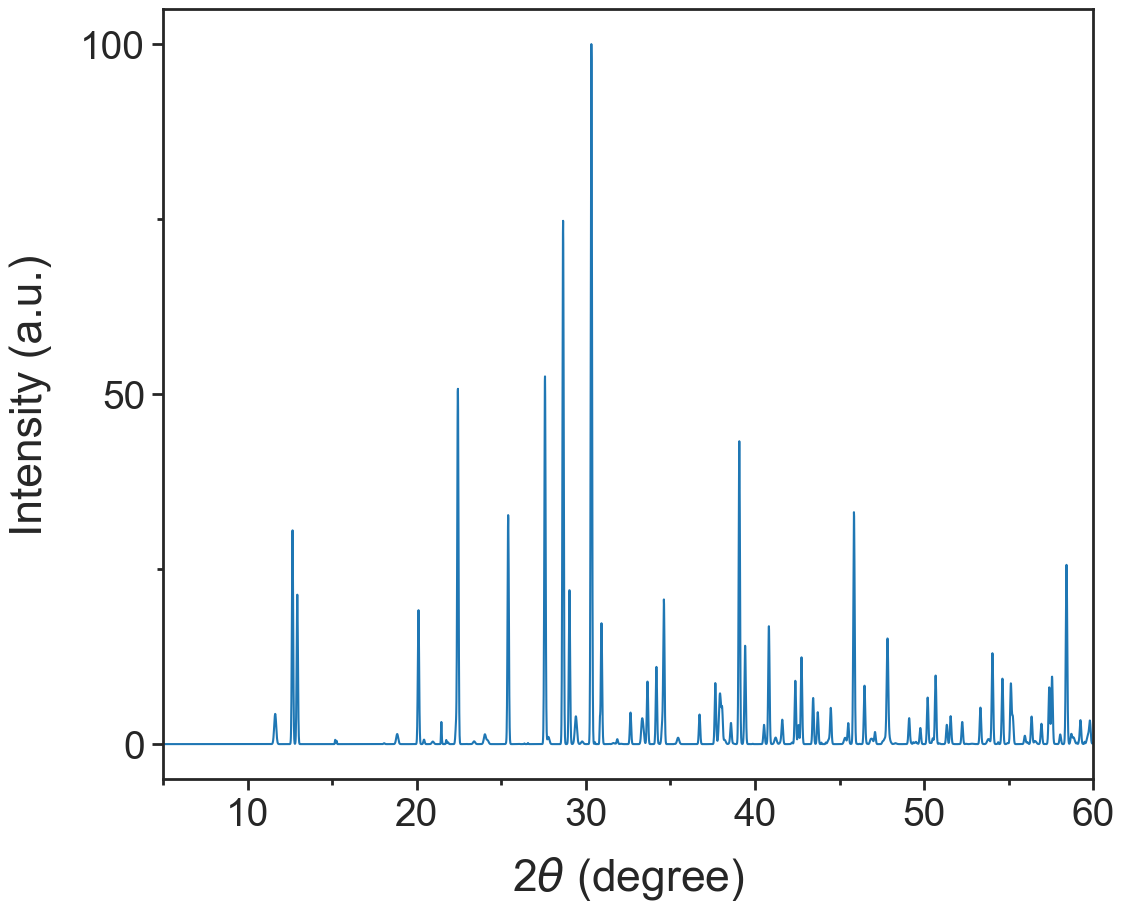

(5501,)


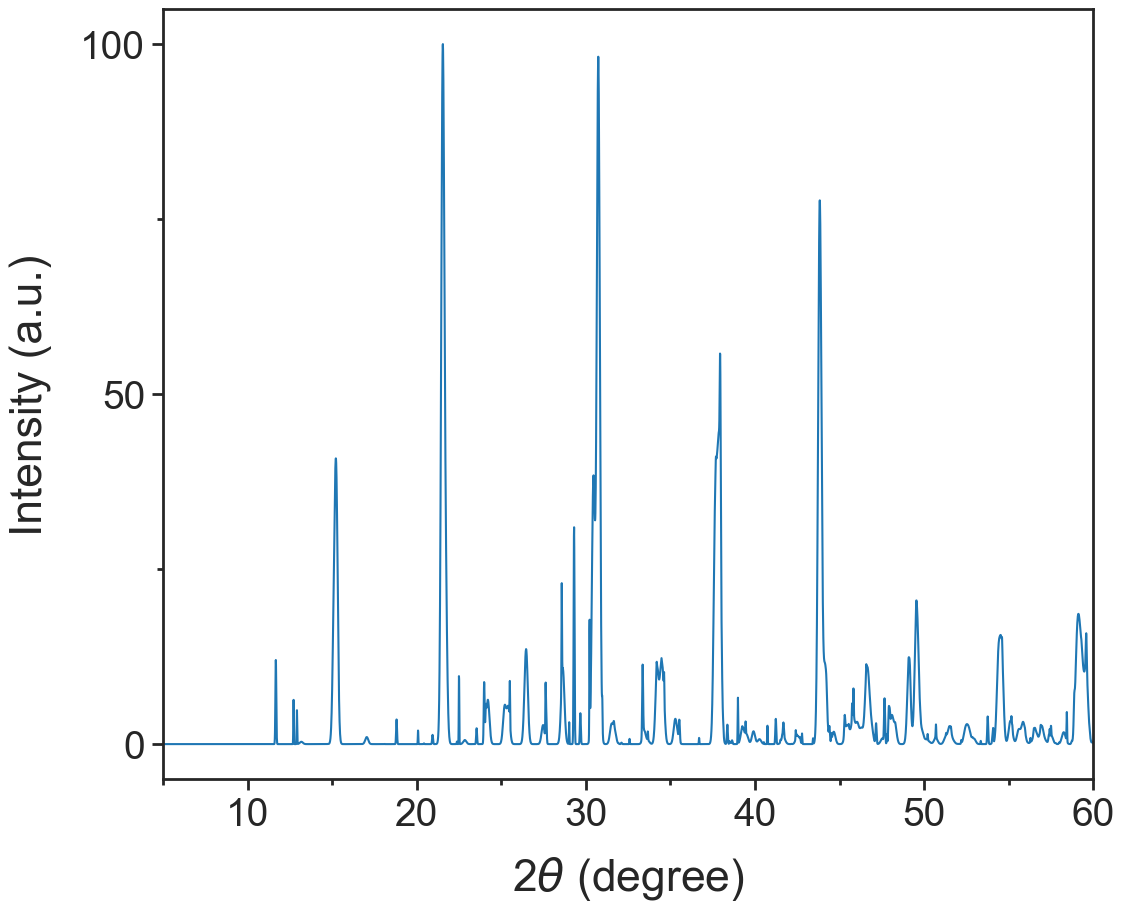

(5501,)


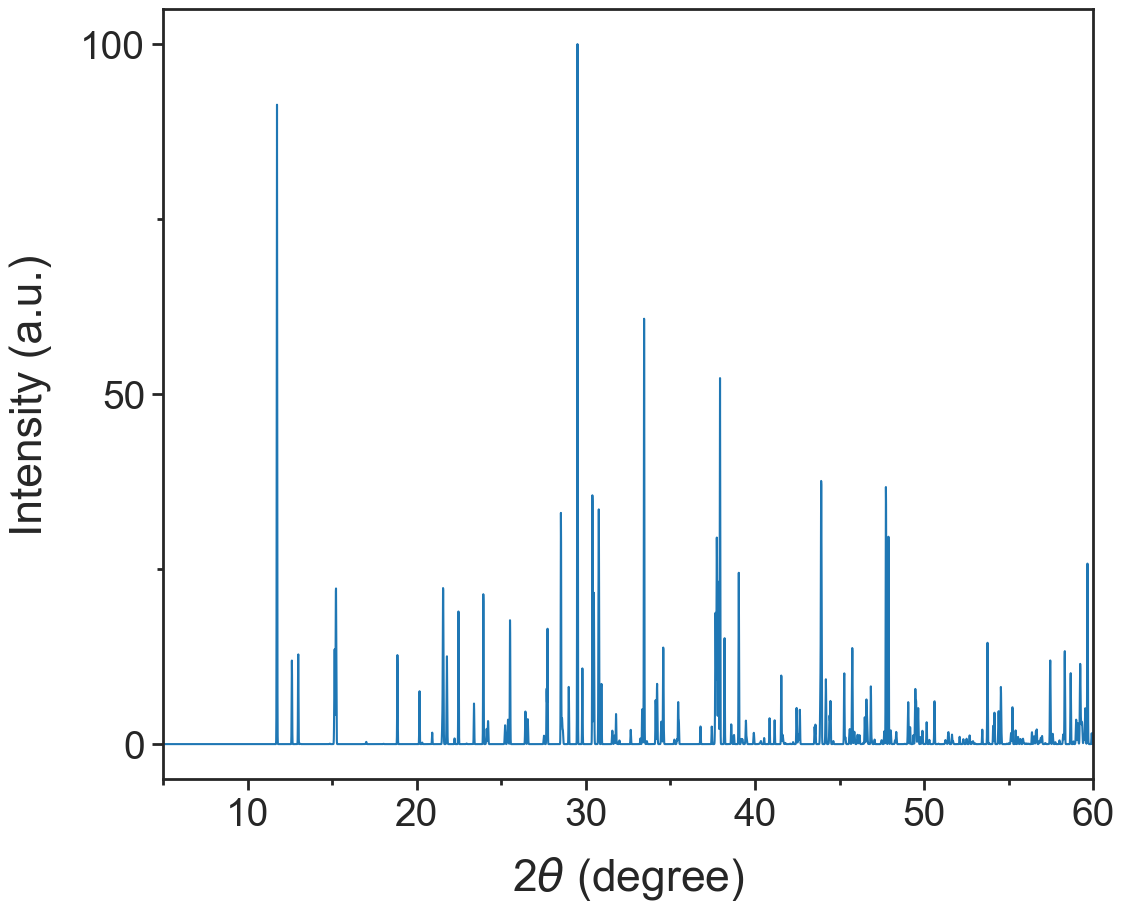

(5501,)


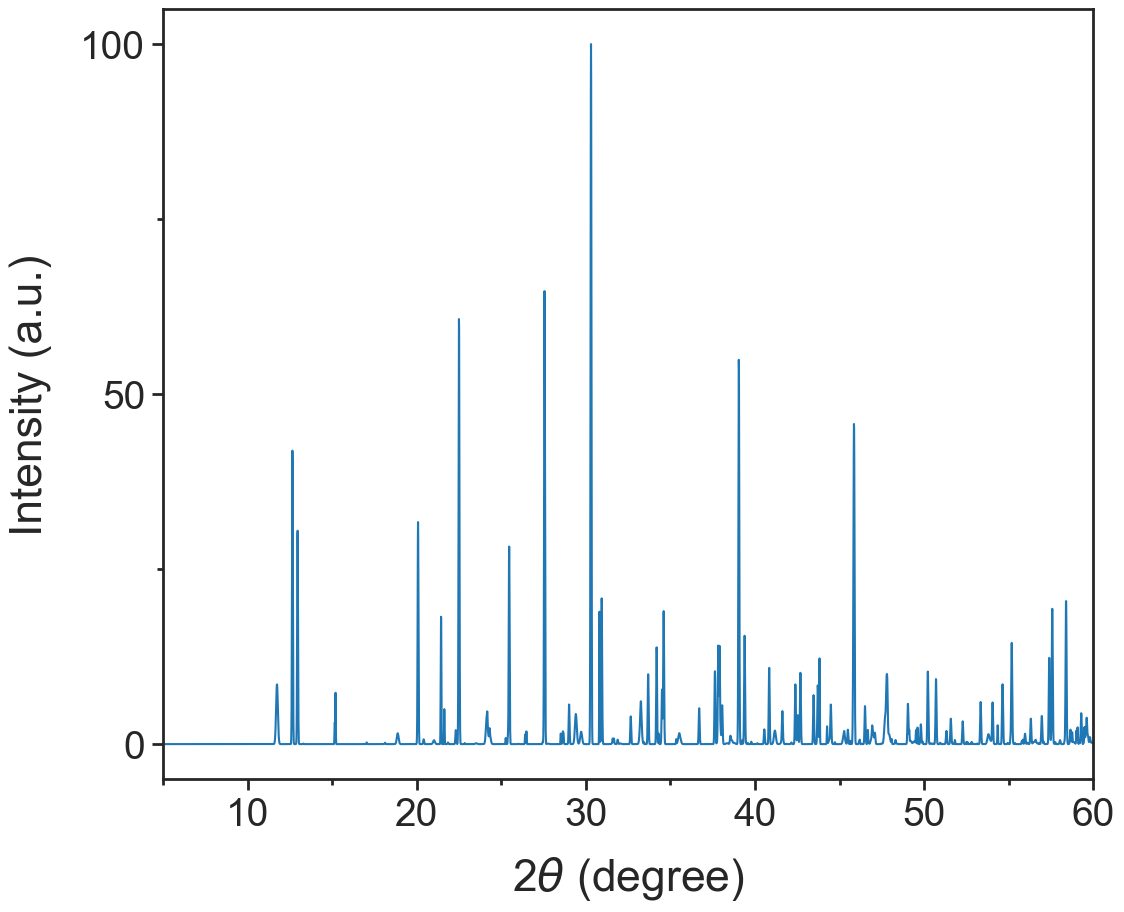

(5501,)


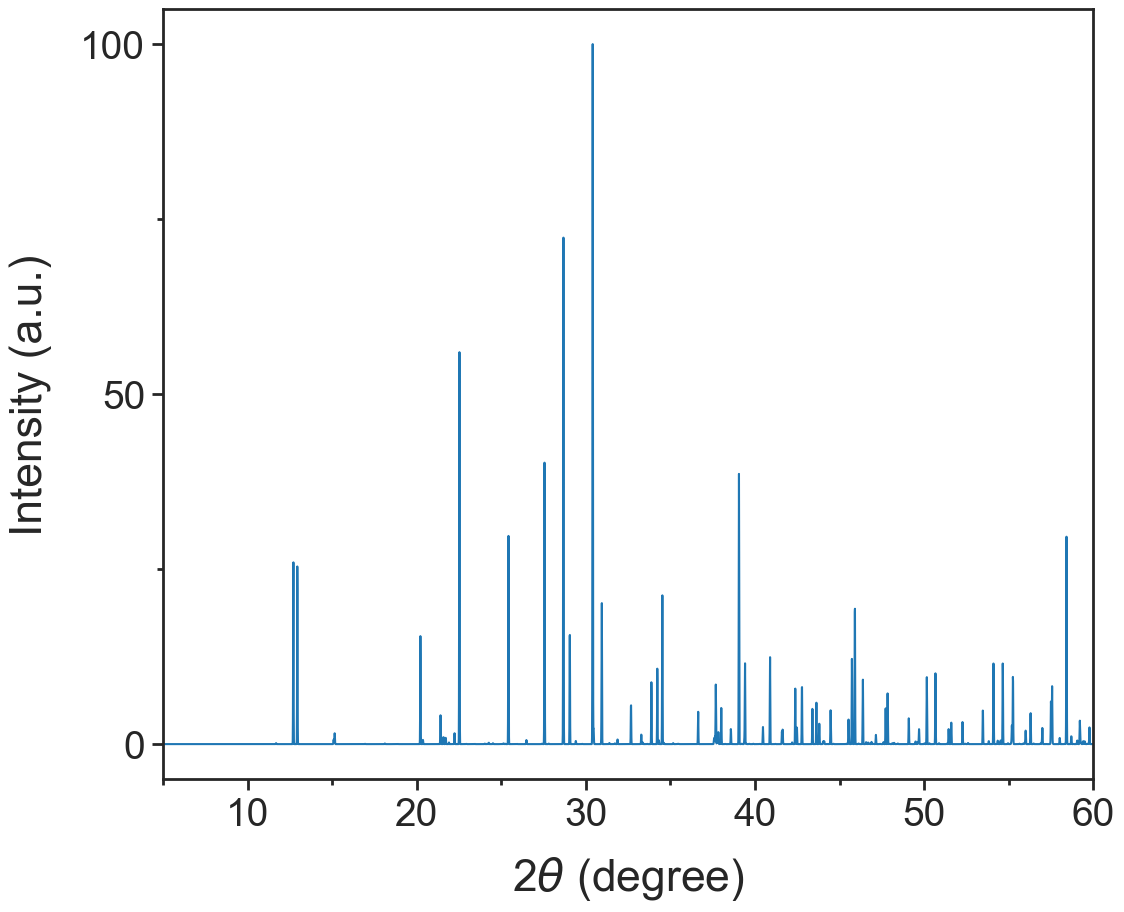

(5501,)


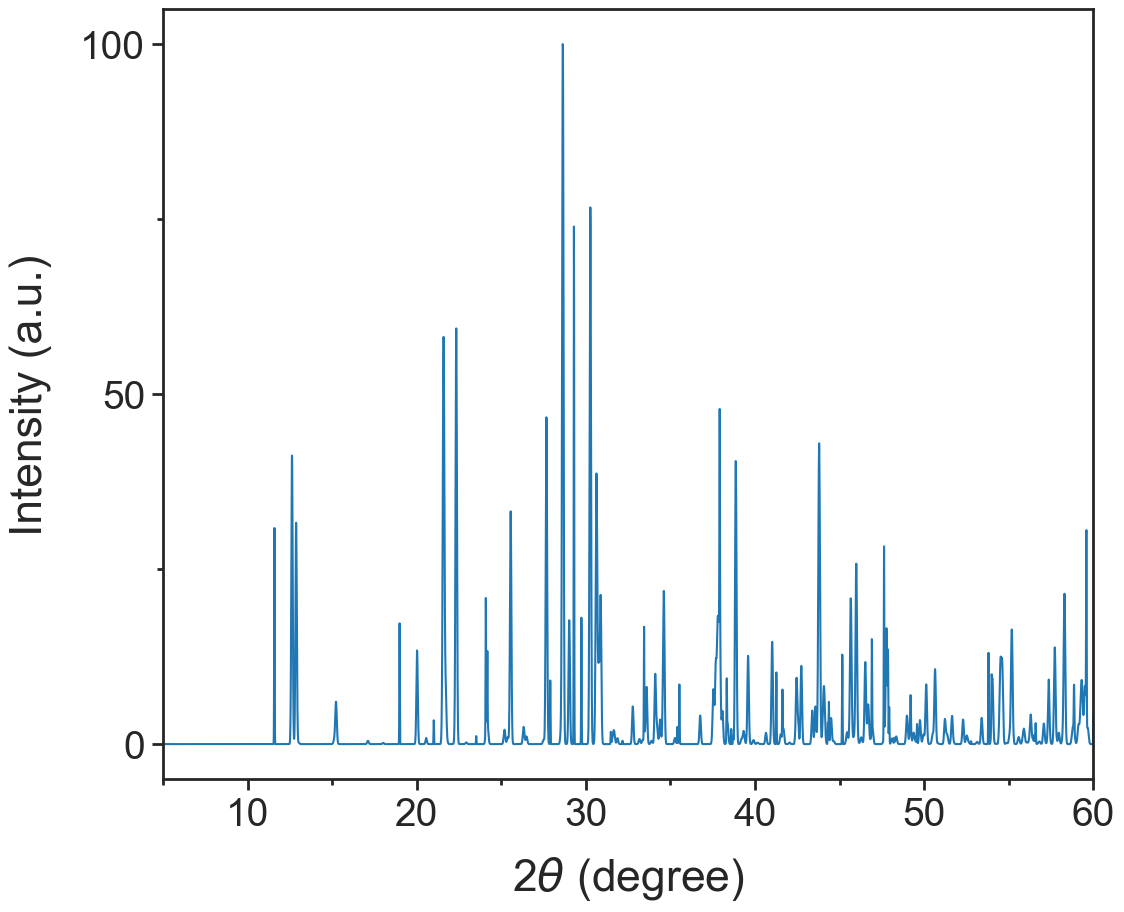

(5501,)


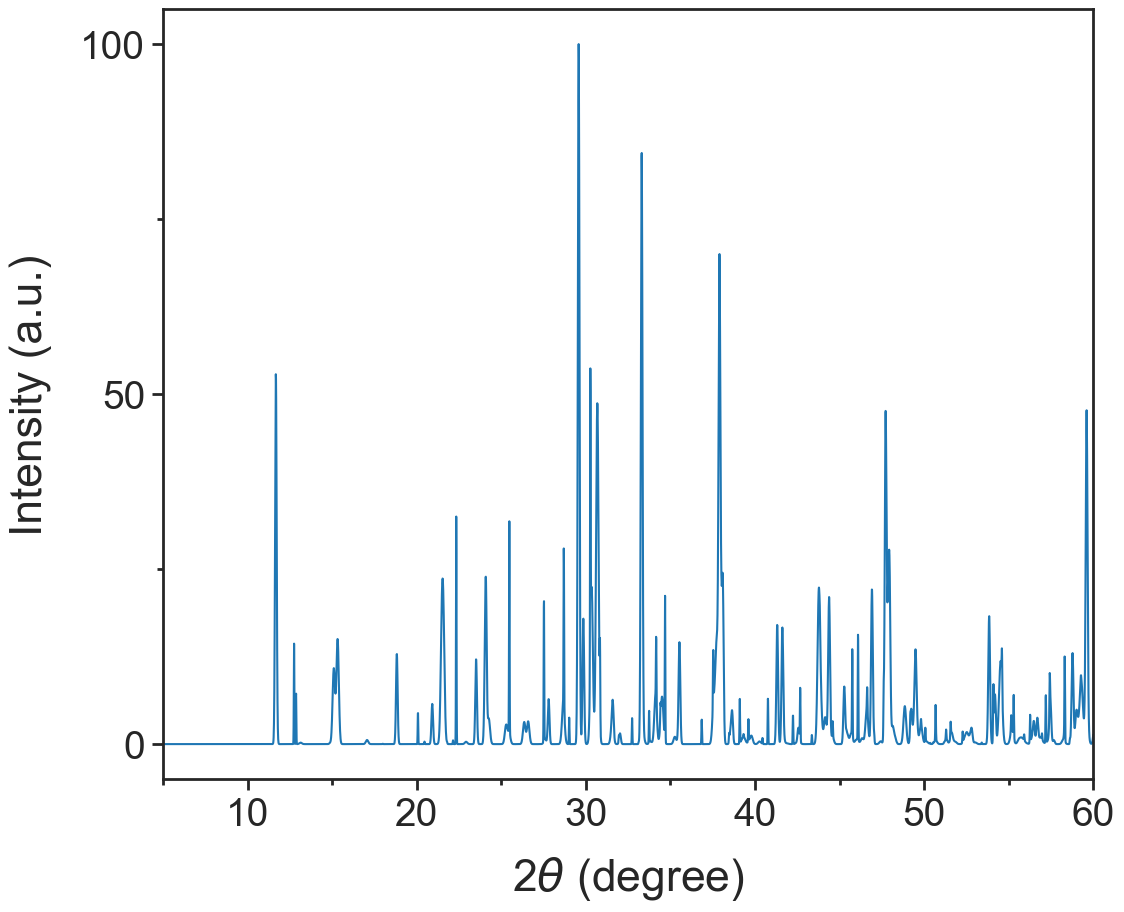

(5501,)


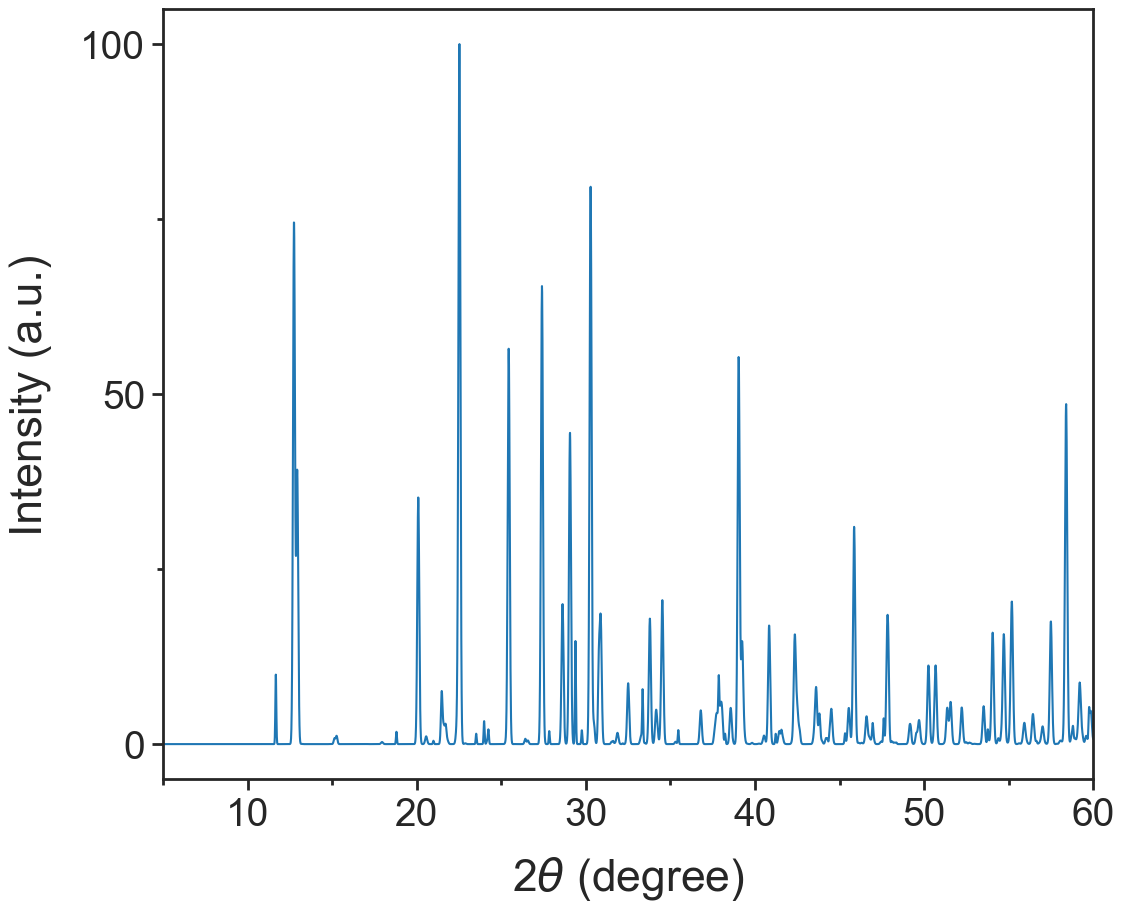

(5501,)


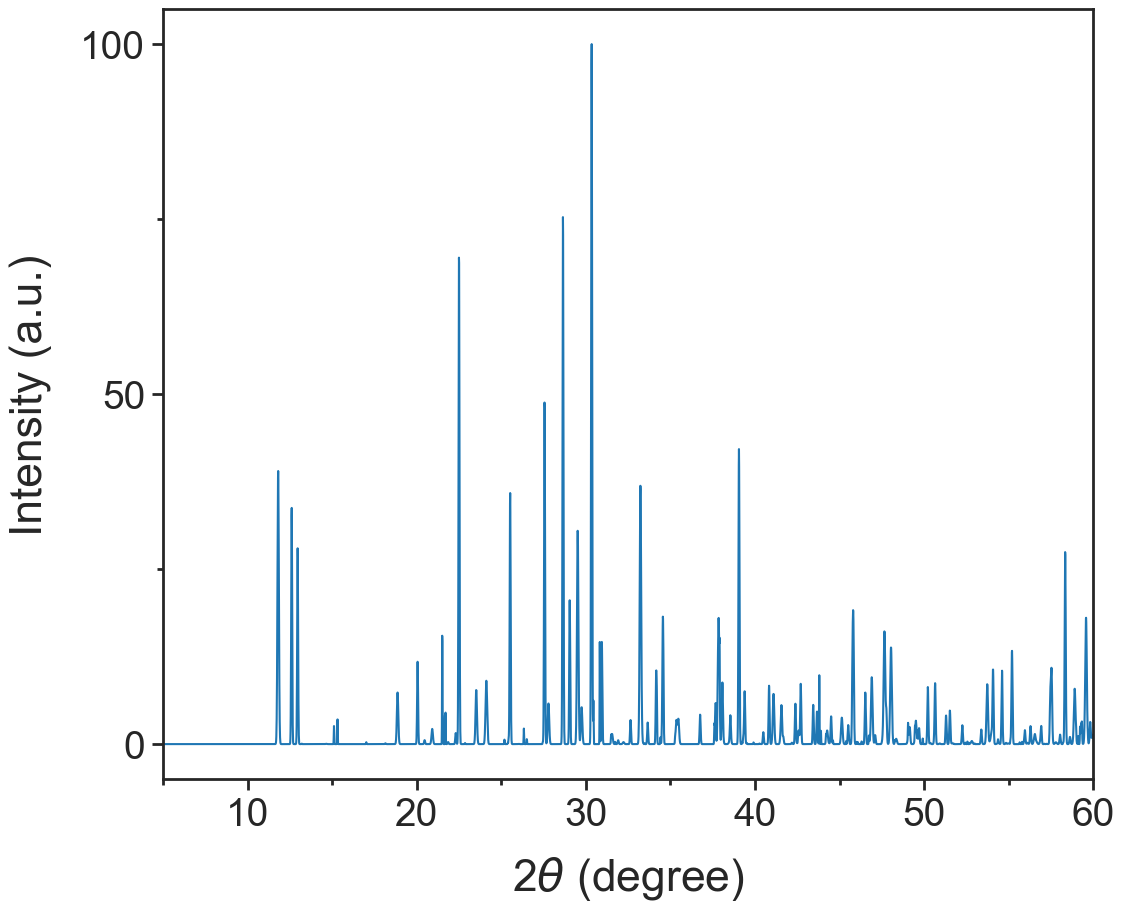

(5501,)


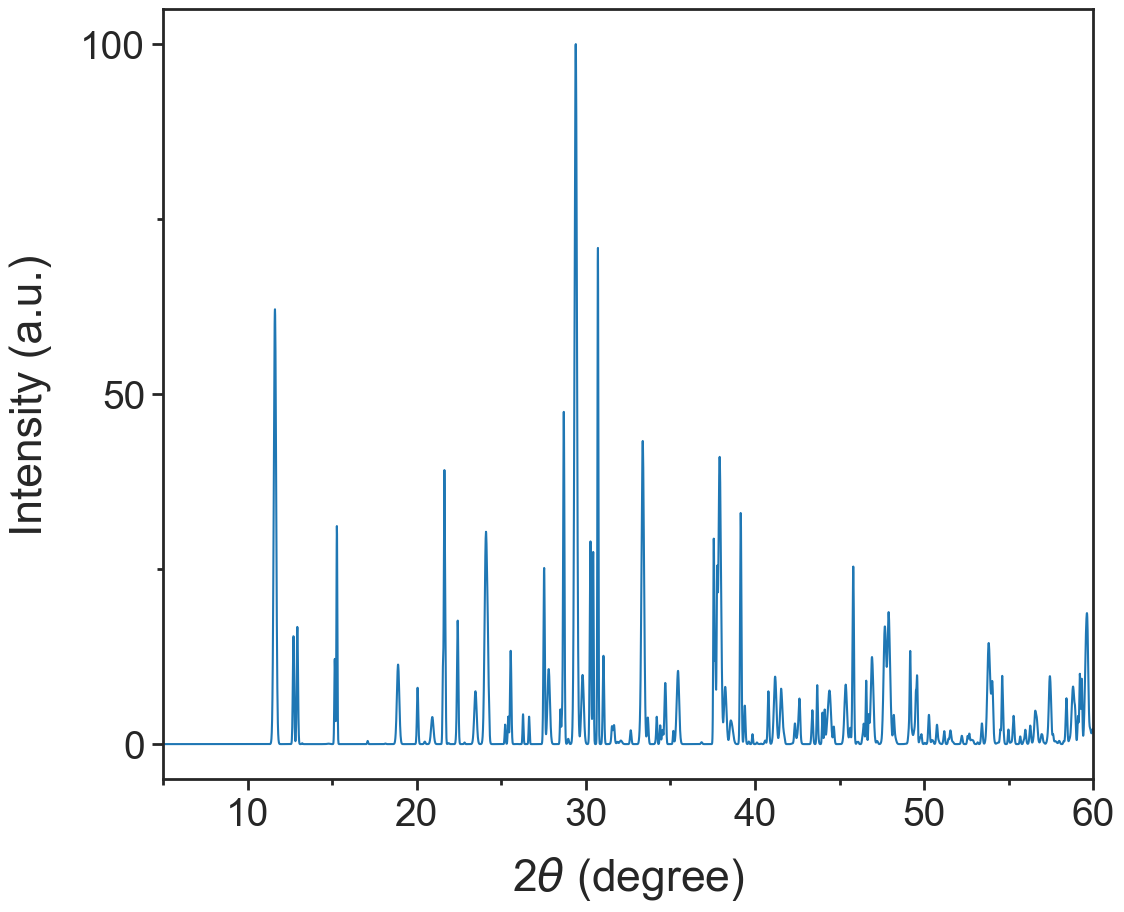

In [346]:
def generate_three_mixed_xrd(idx1,idx2,idx3):   ###idx comes from xrd_dataset.xlsx
    new_texts = []
    new_labels = []
    phase1, text1, label1 = get_simulated_pattern(idx1)
    noisy_phase1 = generate_noisy_xrd(phase1, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text1)
    new_labels.append(label1)
    phase2, text2, label2 = get_simulated_pattern(idx2)
    noisy_phase2 = generate_noisy_xrd(phase2, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text2)
    new_labels.append(label2)
    phase3, text3, label3 = get_simulated_pattern(idx3)
    noisy_phase3 = generate_noisy_xrd(phase3, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text3)
    new_labels.append(label3)
    ratio1 = np.random.uniform(0,1)
    ratio2 = np.random.uniform(0,1. - ratio1)
    ratio3 = 1.- ratio1 - ratio2
    three_mixed_xrd = ratio1 * noisy_phase1 + ratio2 * noisy_phase2 + ratio3 * noisy_phase3
    three_mixed_xrd = three_mixed_xrd / np.max(three_mixed_xrd) * 100.  # Normalize to 100
    return three_mixed_xrd, new_texts, new_labels

# Parameters for generation
crystal_size_range = (5, 50)  # A
position_shift_std_range = (0.01, 0.1)  # degrees 2θ
intensity_variation_std_range = (0.1, 0.5)  # percentage
peak_loss_probability_range = (0.2, 0.5)  # probability of peak loss
num_three_mixed_patterns = 10  # number of noisy patterns to generate per CIF file

# two phases mixed XRD pattern generation
xrd_patterns_list = []
texts_list = []
labels_list = []
idx1 = 10
idx2 = 11
idx3 = 21
for j in range(0,num_three_mixed_patterns):
    three_mixed_xrd, texts, labels = generate_three_mixed_xrd(idx1,idx2,idx3)
    print(three_mixed_xrd.shape)
    # Plot the XRD pattern
    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.plot(two_theta_range, three_mixed_xrd)
    ax.set_xlabel(r'2$\theta$ (degree)',labelpad=15,size=32)
    ax.set_ylabel('Intensity (a.u.)',labelpad=20,size=32)
    # ax.set_title('CsBiI-CsBiBr')
    # ax.set_ylim(-5,105)
    ax.set_xlim(5, 60)
    ax.tick_params(axis='both', direction='out', length=8, width=2, pad=5, labelsize=28)
    ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=5)
    ax.minorticks_on()
    ax.yaxis.set_ticks([])
    # plt.legend(fontsize=16)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=False, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    # plt.savefig(f'/Users/shengfang/Dropbox (MIT)/high entropy/XRD/20240821/figure.svg', bbox_inches='tight',format='svg', dpi=300)
    # plt.savefig(f'/Users/shengfang/Dropbox (MIT)/high entropy/XRD/20240821/figure.png', bbox_inches='tight',format='png', dpi=300)
    plt.show()
    three_mixed_xrd_str = ";".join(map(str, three_mixed_xrd))
    xrd_patterns_list.append(three_mixed_xrd_str)
    texts_list.append(texts)
    labels_list.append(labels)

df = pd.DataFrame({
    "xrd_patterns": xrd_patterns_list,
    "texts": texts_list,
    "labels": labels_list
})
output_excel_path = f'/Users/shengfang/Dropbox (MIT)/XRD phase identification/three_mixed_dataset_{idx1}_{idx2}_{idx3}.xlsx'
df.to_excel(output_excel_path, index=False)